This notebook attempts to answer the following question.

```
Question: Is there an optimal date where the calibration is optimal (in the sense that x% of data live in the x% CrI).
```

We compute the calibration for each date within the time-series separately both for parameters and data.

Rerun for only 100 parameter runs since it takes FOREVER to do the full set. Rerun for full set if there's anything interesting.

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import glob
import pickle
from tqdm import tqdm

from epyfilter import posterior_checks


In [84]:
# choose one param as an example
param_list = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/good_param_list.csv")
pp = param_list.iat[42365, 0]

In [86]:
# directory has pkls saved for each 100 runs (ran this for potential example plots for the paper before)
run_dir = "/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"

def open_pickle(pickle_file):
    with open(f"{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    return data

In [189]:

percentiles = np.zeros((100, 365))
for run in tqdm(range(100)):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle_rt(file)
    
    truth = eakf.data.beta * eakf.data.t_I
    post_rts = np.sort(np.array([θ.beta * θ.t_I for θ in eakf.θ_list]), axis=1)
    
    # find which index in ensemble post_rts[i-1,:] <= truth[:] < post_rts[i,:]
    idx = (post_rts.T < truth).sum(axis=0)

    # map from index to percentile p (smallest one where truth lives within p% CrI)
    # each ensemble member has mass 1 / eakf.m
    # for cases where the truth does not lie within idx = 0 or idx = 300
    n_ens = eakf.m
    percentiles[run,:] = np.maximum(1 - 2*idx/n_ens, 2*idx/n_ens - 1)
    
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


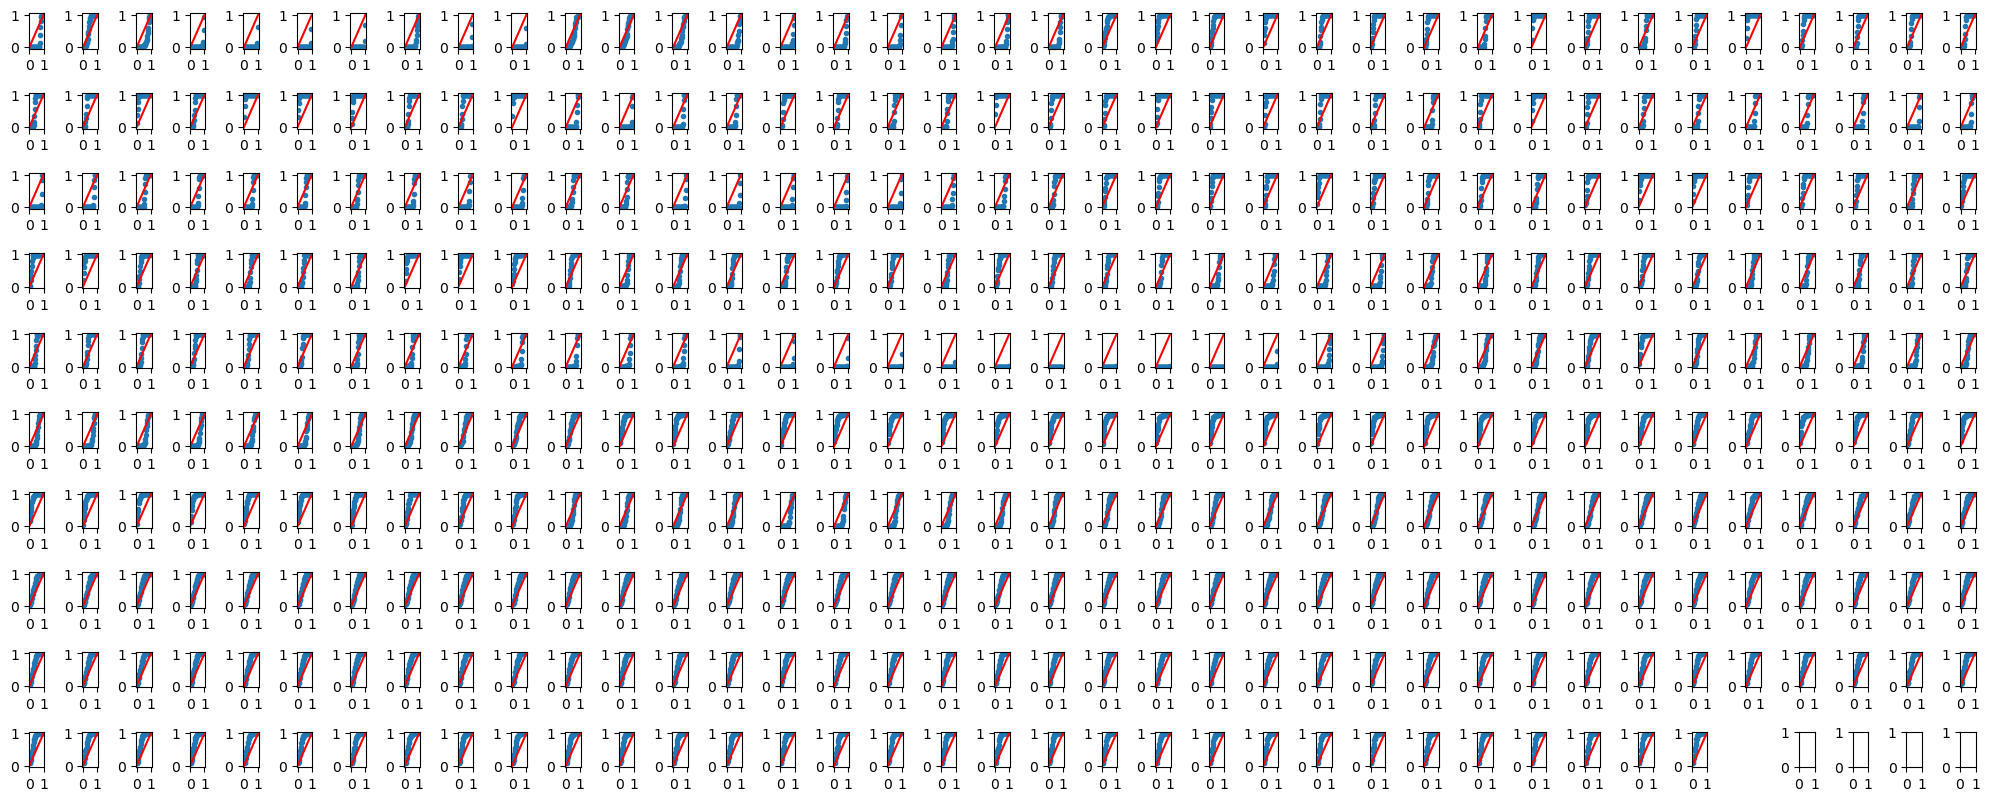

In [295]:
p_list = np.arange(.025, 1, .025)

fig_width = 20  # Example width in inches
fig_height = fig_width * (10 / 37) * 1.5  # Adjust aspect ratio as needed

fig, axs = plt.subplots(10,37, figsize=(fig_width, fig_height))


scores = []
for i, ax in enumerate(axs.flat):
    if i > 364:
        ax.axis("off")
        break
    ax.plot(p_list, [(percentiles[:,i] < p).sum() / 100 for p in p_list], '.')
    ax.axline((0, 0), (1, 1), color='r')
    scores.append(np.mean((p_list - [(percentiles[:,i] < p).sum() / 100 for p in p_list]) ** 2))

plt.tight_layout()
plt.show()

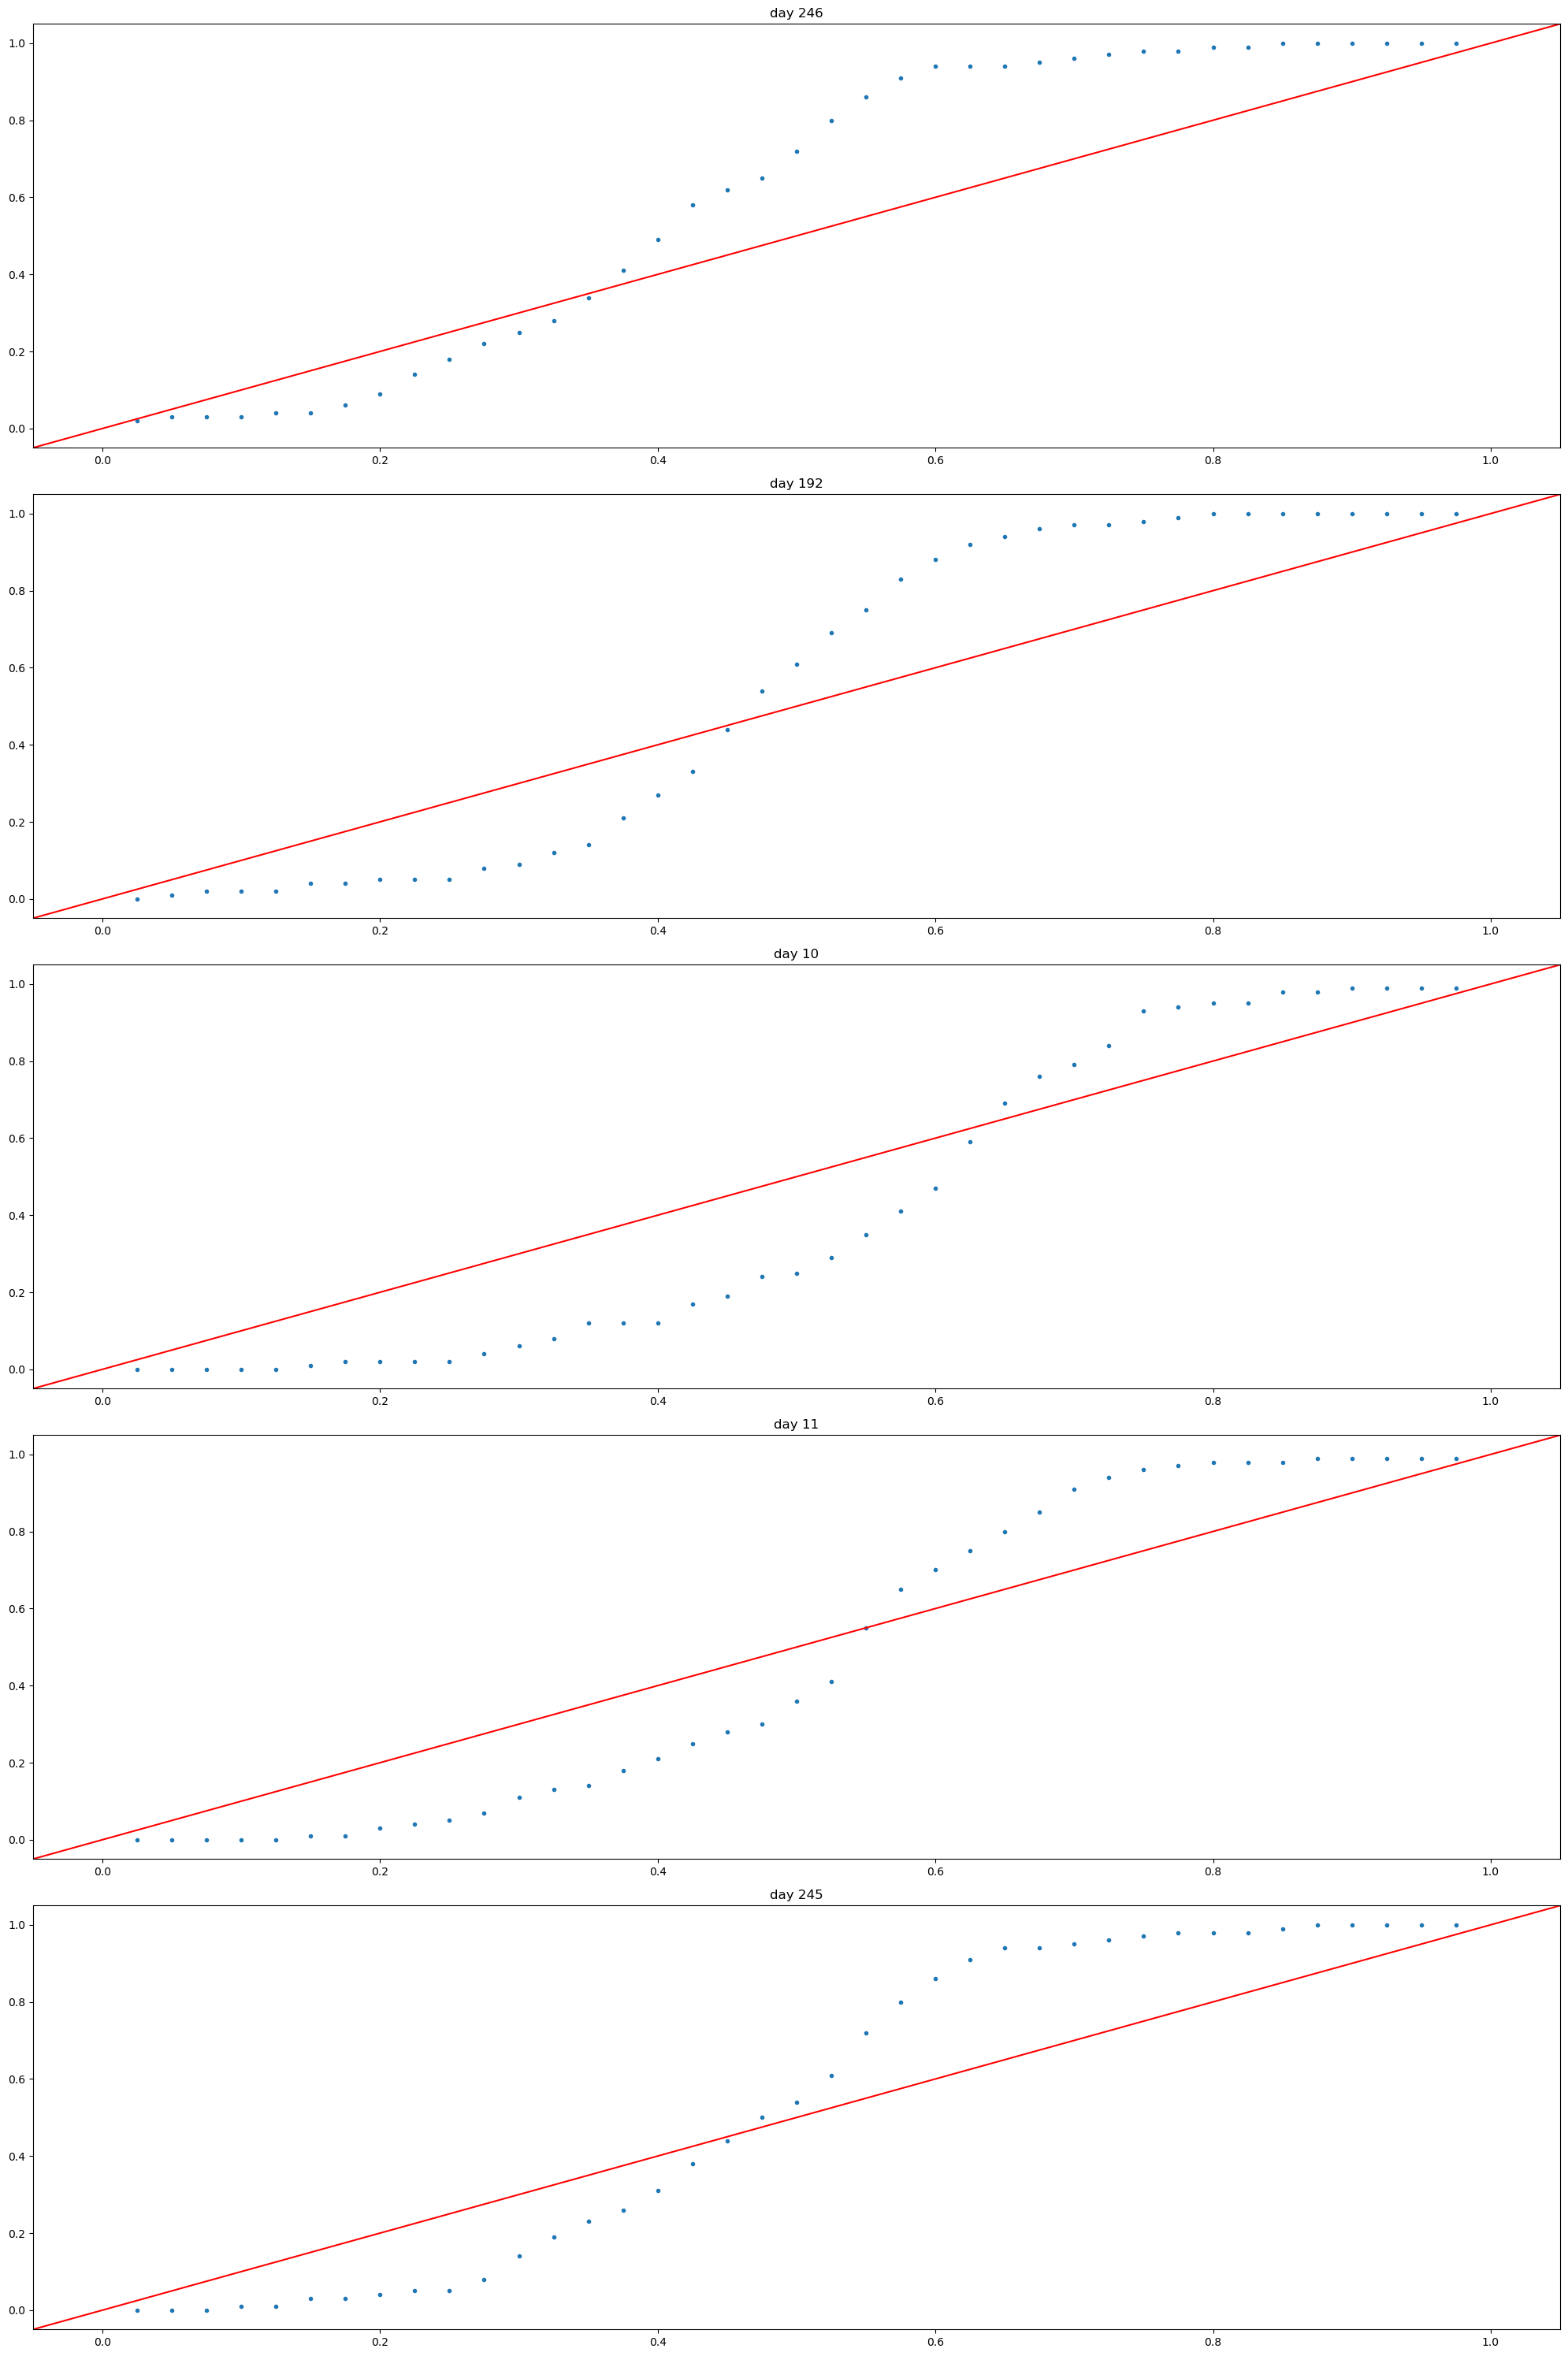

In [296]:
best_scores_idx = np.argpartition(-np.array(scores), -5)[-5:]

fig, axs = plt.subplots(5, figsize=(20, 30))
for i, ax in enumerate(axs.flat):
    ax.plot(p_list, [(percentiles[:,best_scores_idx[i]] < p).sum() / 100 for p in p_list], '.')
    ax.axline((0, 0), (1, 1), color='r')
    ax.set_title(f"day {best_scores_idx[i]}")

plt.tight_layout()
plt.show()

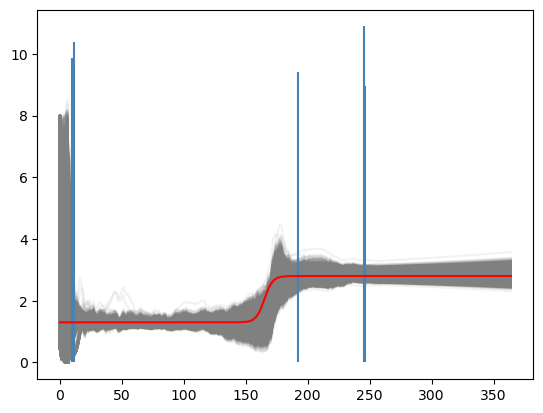

In [297]:
fig, ax = plt.subplots()

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle_rt(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    ax.plot(post_rts, color='gray', alpha=0.1)

for day in best_scores_idx:
    ax.vlines(day, 0.01, ax.get_ylim()[1], color='steelblue', label='last epi day')
ax.plot(truth, color='r')

In [304]:
best_scores_idx

array([246, 192,  10,  11, 245])

In [306]:
blah_list = []

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle_rt(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    blah_list.append(post_rts[best_scores_idx,:])

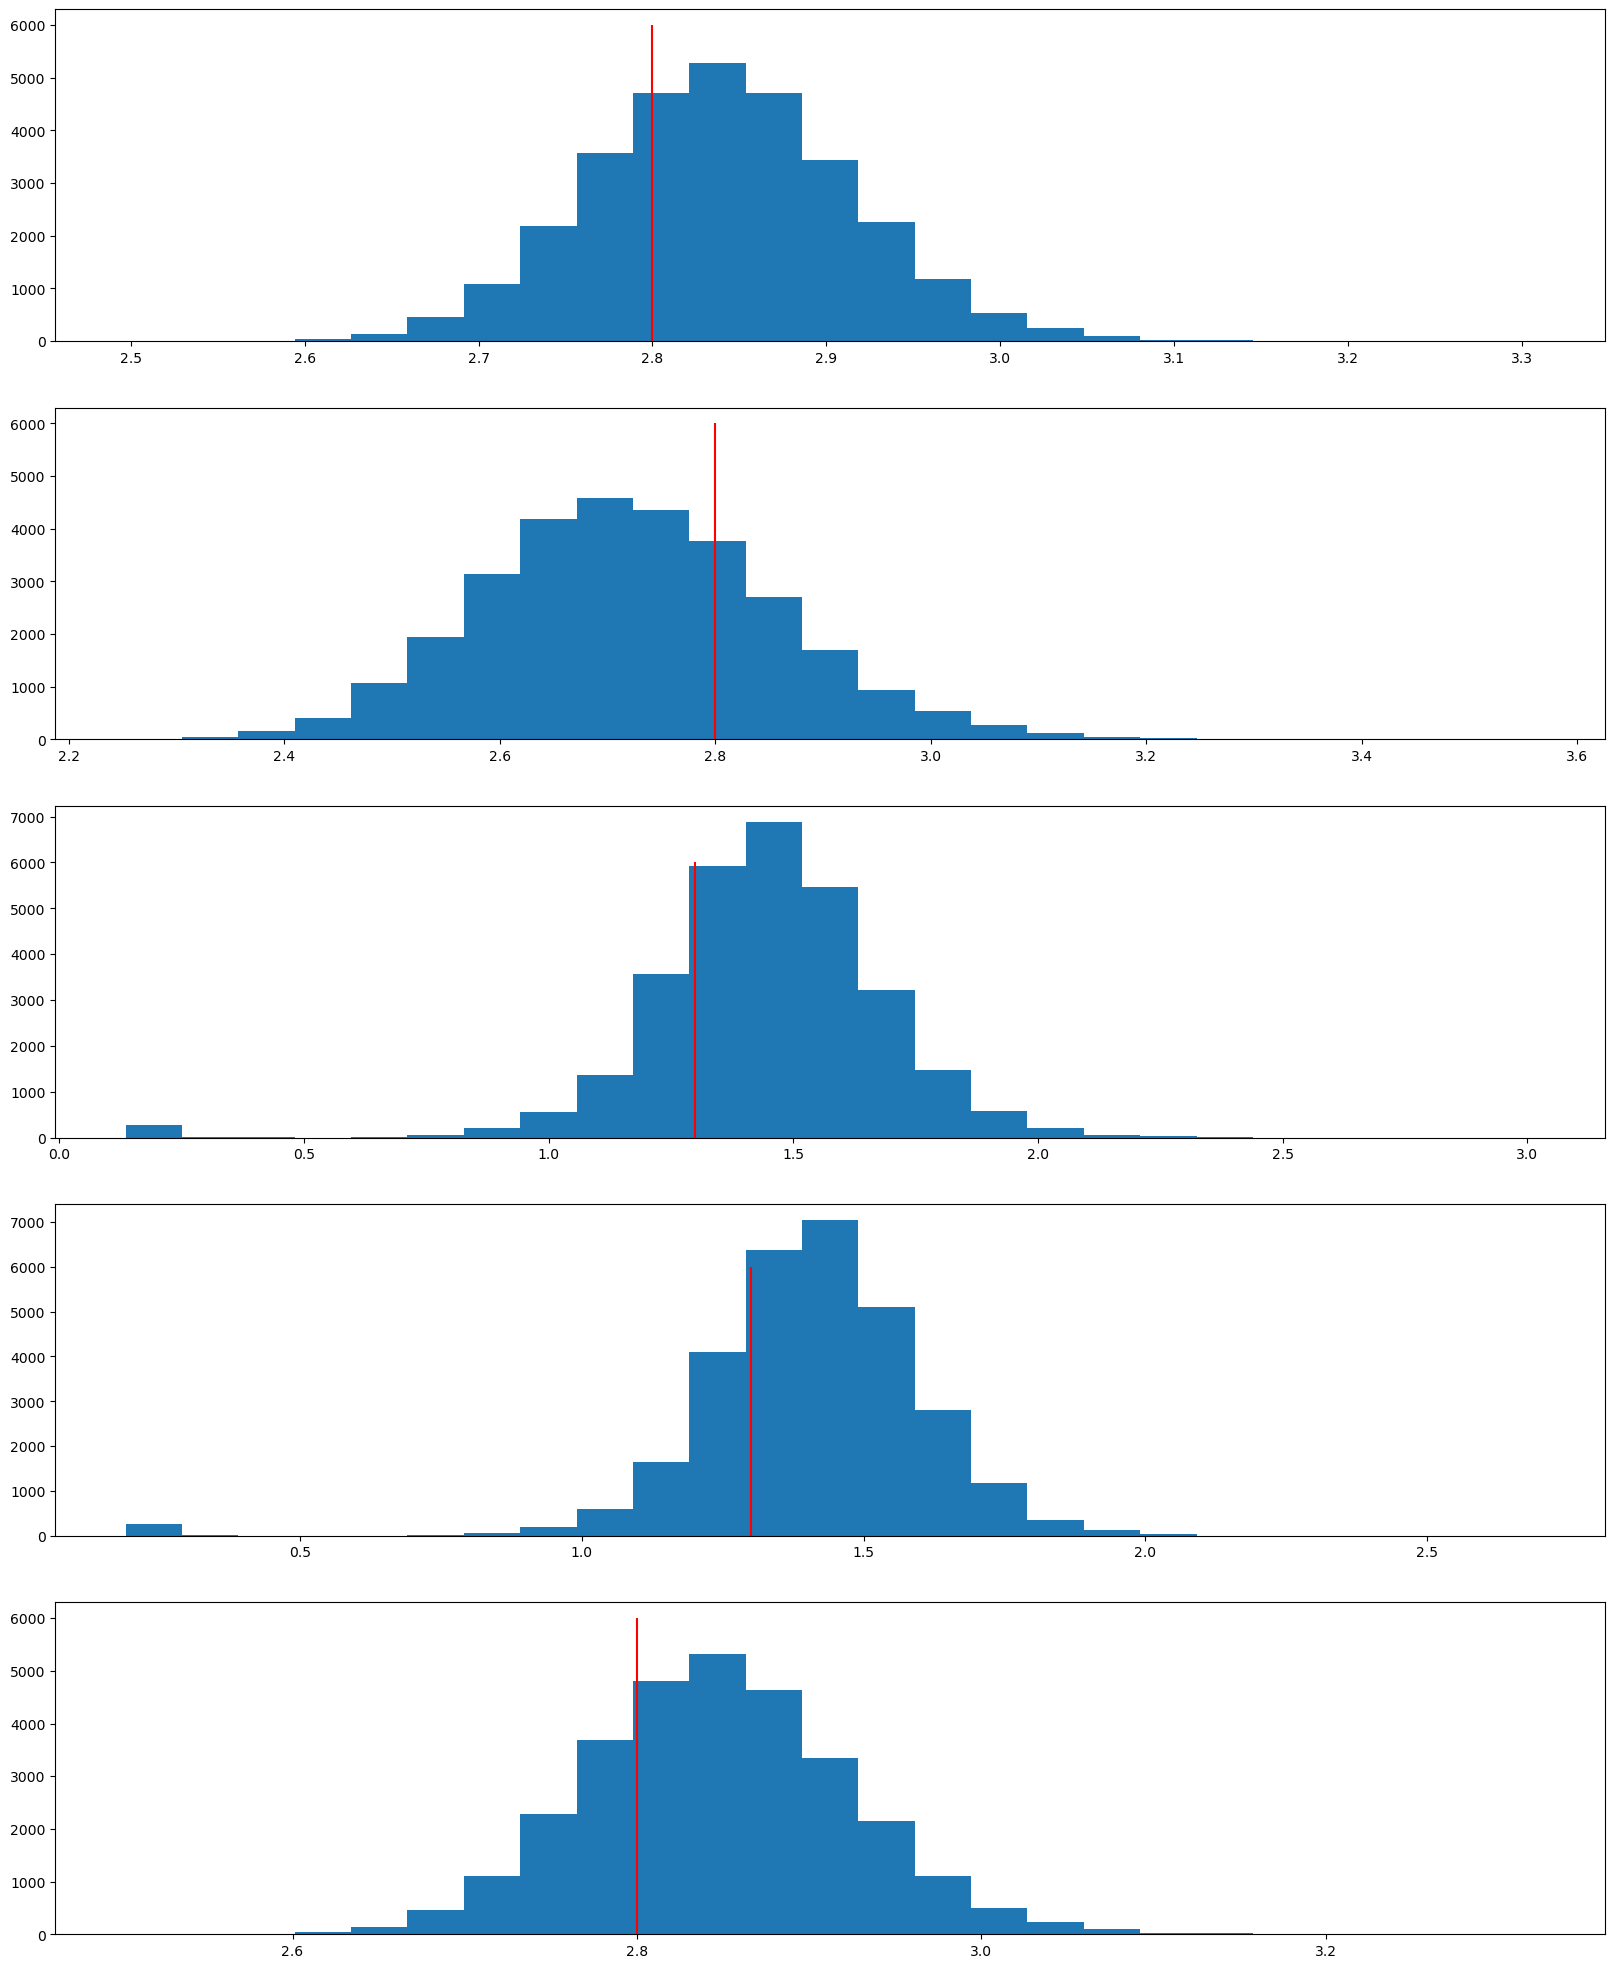

In [332]:
fig, axs = plt.subplots(5, figsize=(20,25))
for i, ax in enumerate(axs.flat):
    ax.hist(np.array(blah_list)[:,i,:].flatten(), bins=25)
    ax.vlines(truth[best_scores_idx[i]], 0, 6000, color='red')

This is dumb and slow. There's probably a faster and better way to do this. How about looking in `percentiles` for days that are close to 0

In [356]:
percentiles_mean_run = np.mean(percentiles, axis=0)

In [371]:
best_scores_idx = np.argsort(percentiles_mean_run)[:5]

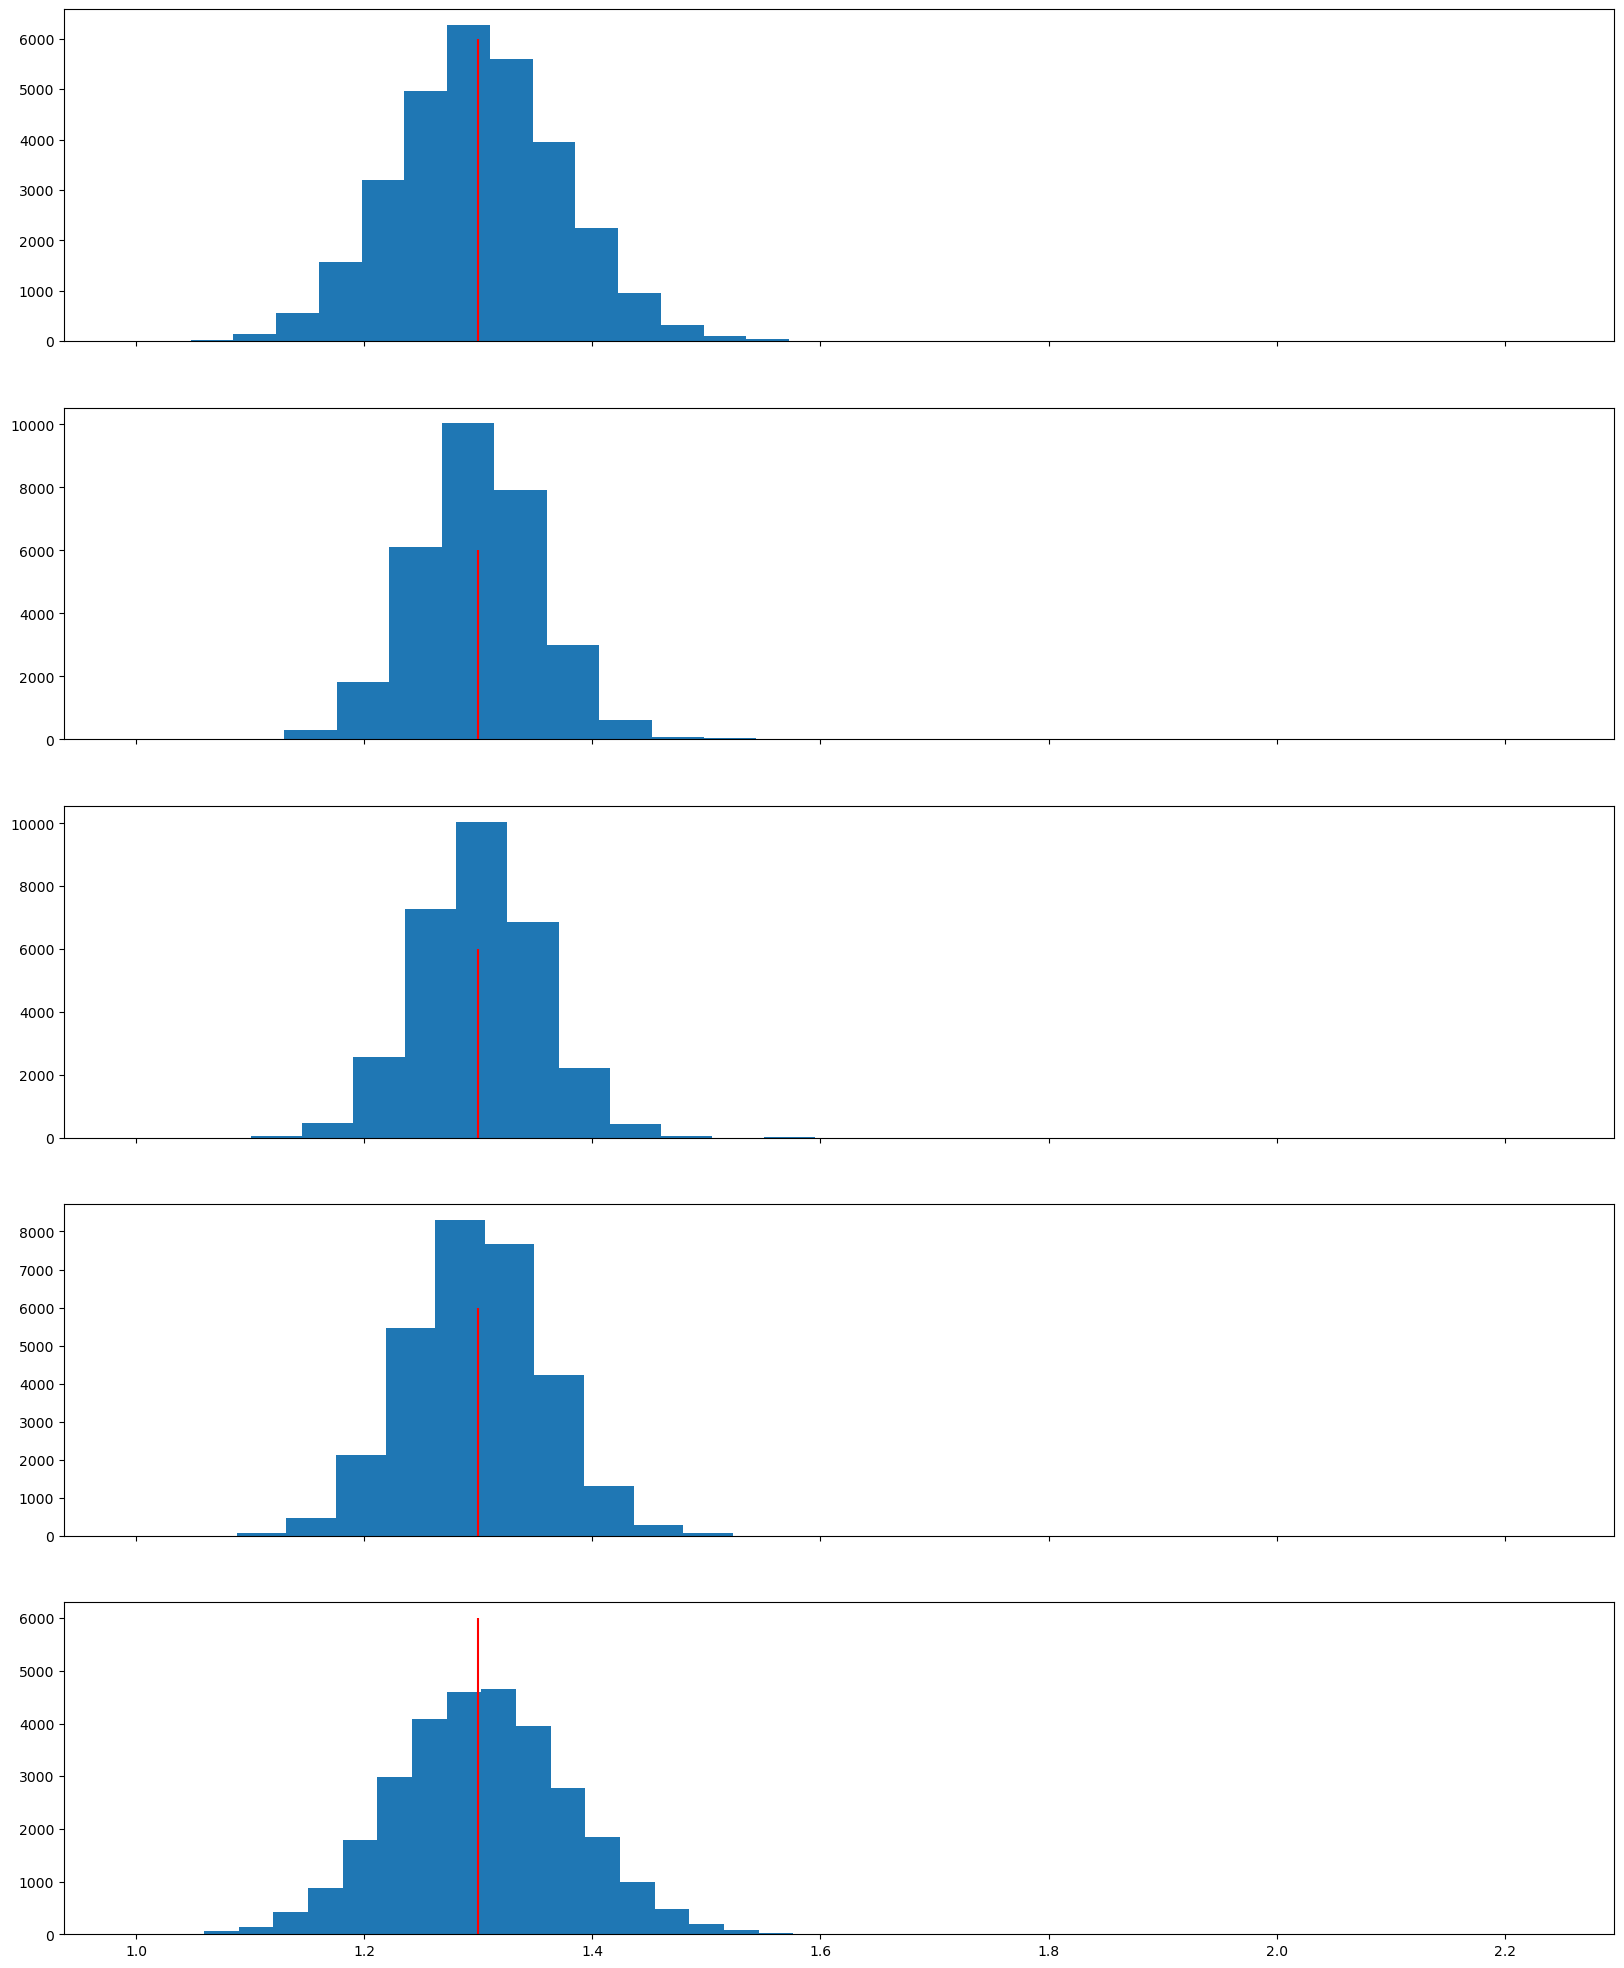

In [365]:
blah_list = []

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle_rt(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    blah_list.append(post_rts[best_scores_idx,:])

fig, axs = plt.subplots(5, figsize=(20,25), sharex=True)
for i, ax in enumerate(axs.flat):
    ax.hist(np.array(blah_list)[:,i,:].flatten(), bins=25)
    ax.vlines(truth[best_scores_idx[i]], 0, 6000, color='red')

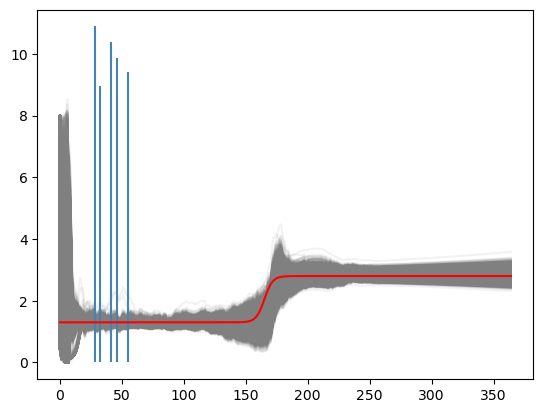

In [366]:
fig, ax = plt.subplots()

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle_rt(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    ax.plot(post_rts, color='gray', alpha=0.1)

for day in best_scores_idx:
    ax.vlines(day, 0.01, ax.get_ylim()[1], color='steelblue', label='last epi day')
ax.plot(truth, color='r')

In [388]:
pd.DataFrame(post_rts)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,6.044534,3.930679,1.599004,6.075267,3.967933,7.717498,5.093451,7.793970,2.107750,3.602428,...,7.259456,0.456980,6.238816,4.212456,7.608490,7.058181,3.505744,0.919143,1.277598,4.812396
1,4.248168,3.449446,0.340721,2.080601,1.981811,6.283027,4.358669,5.648063,1.968970,2.138795,...,2.008792,0.195476,1.783631,1.087187,7.327747,1.614521,3.139134,0.207650,0.502921,2.324644
2,4.970091,3.904178,0.768087,3.093099,3.025158,6.375535,4.780065,5.875410,2.129146,3.153781,...,2.850129,0.391476,2.732442,2.022066,7.383932,2.474268,3.468979,0.468334,0.965614,3.527708
3,5.582996,4.261993,2.236479,4.676593,4.783897,6.440928,5.040406,6.003021,2.351120,4.924963,...,4.196161,1.011640,4.417558,4.428902,7.426513,4.073316,3.791537,1.366401,2.445413,5.291632
4,5.534985,4.213982,5.455847,4.628582,4.735886,6.392917,4.992395,5.955010,2.388833,4.876952,...,4.148150,2.461705,4.369546,5.498123,7.403798,4.025305,3.743526,3.800192,4.794885,5.243621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2.880745,2.471468,2.890691,2.876746,2.958222,2.752662,2.676732,2.895182,2.865595,2.828537,...,2.801033,2.960908,2.877695,3.029191,2.618900,2.853669,2.682922,2.790866,2.887192,2.847486
361,2.880915,2.469592,2.890910,2.876896,2.958780,2.752191,2.675882,2.895424,2.865690,2.828446,...,2.800805,2.961479,2.877850,3.030104,2.617760,2.853704,2.682103,2.790586,2.887394,2.847489
362,2.881127,2.467721,2.891146,2.877062,2.959355,2.751733,2.675042,2.895682,2.865799,2.828370,...,2.800590,2.962067,2.878020,3.031035,2.616630,2.853754,2.681294,2.790320,2.887612,2.847508
363,2.881336,2.465840,2.891383,2.877228,2.959932,2.751273,2.674198,2.895941,2.865909,2.828292,...,2.800374,2.962658,2.878191,3.031971,2.615494,2.853803,2.680482,2.790053,2.887831,2.847526


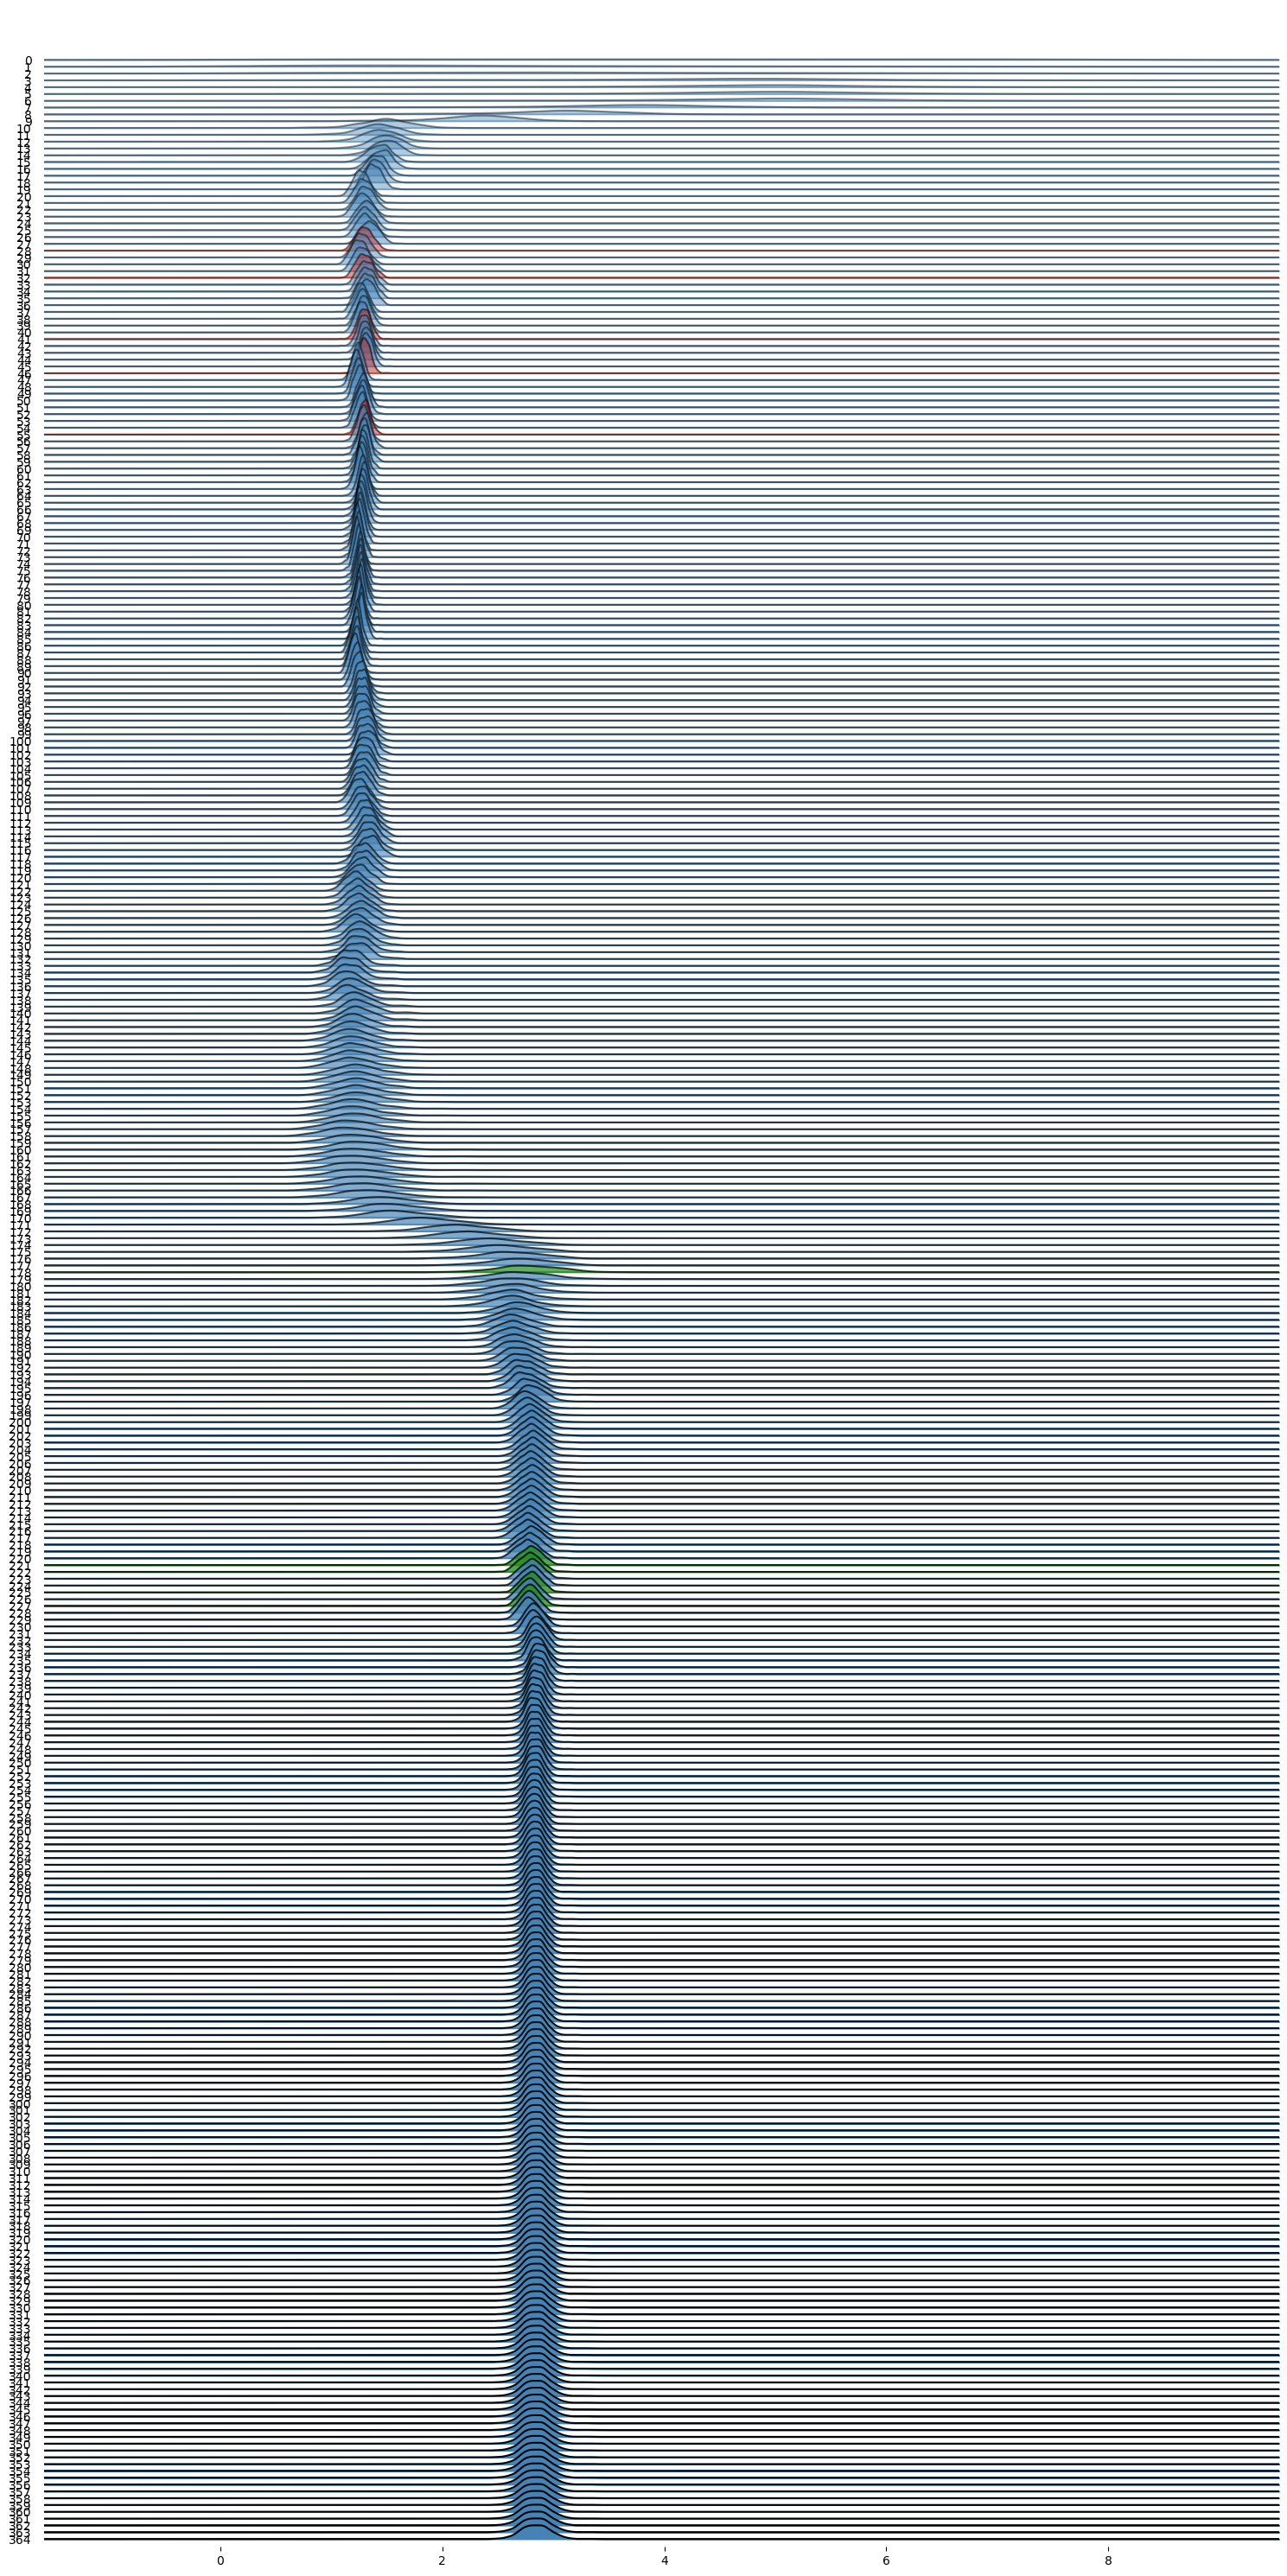

In [405]:
import joypy

df = pd.DataFrame(post_rts.T)

colors = ["#4682B4"] * 365
for idx in best_scores_idx:
    colors[idx] = "#B22222"
for idx in best_scores_after_midpoint_idx:
    colors[idx] = "#228B22"

fig, axes = joypy.joyplot(df, fade=True, figsize=(15,30), color=colors)

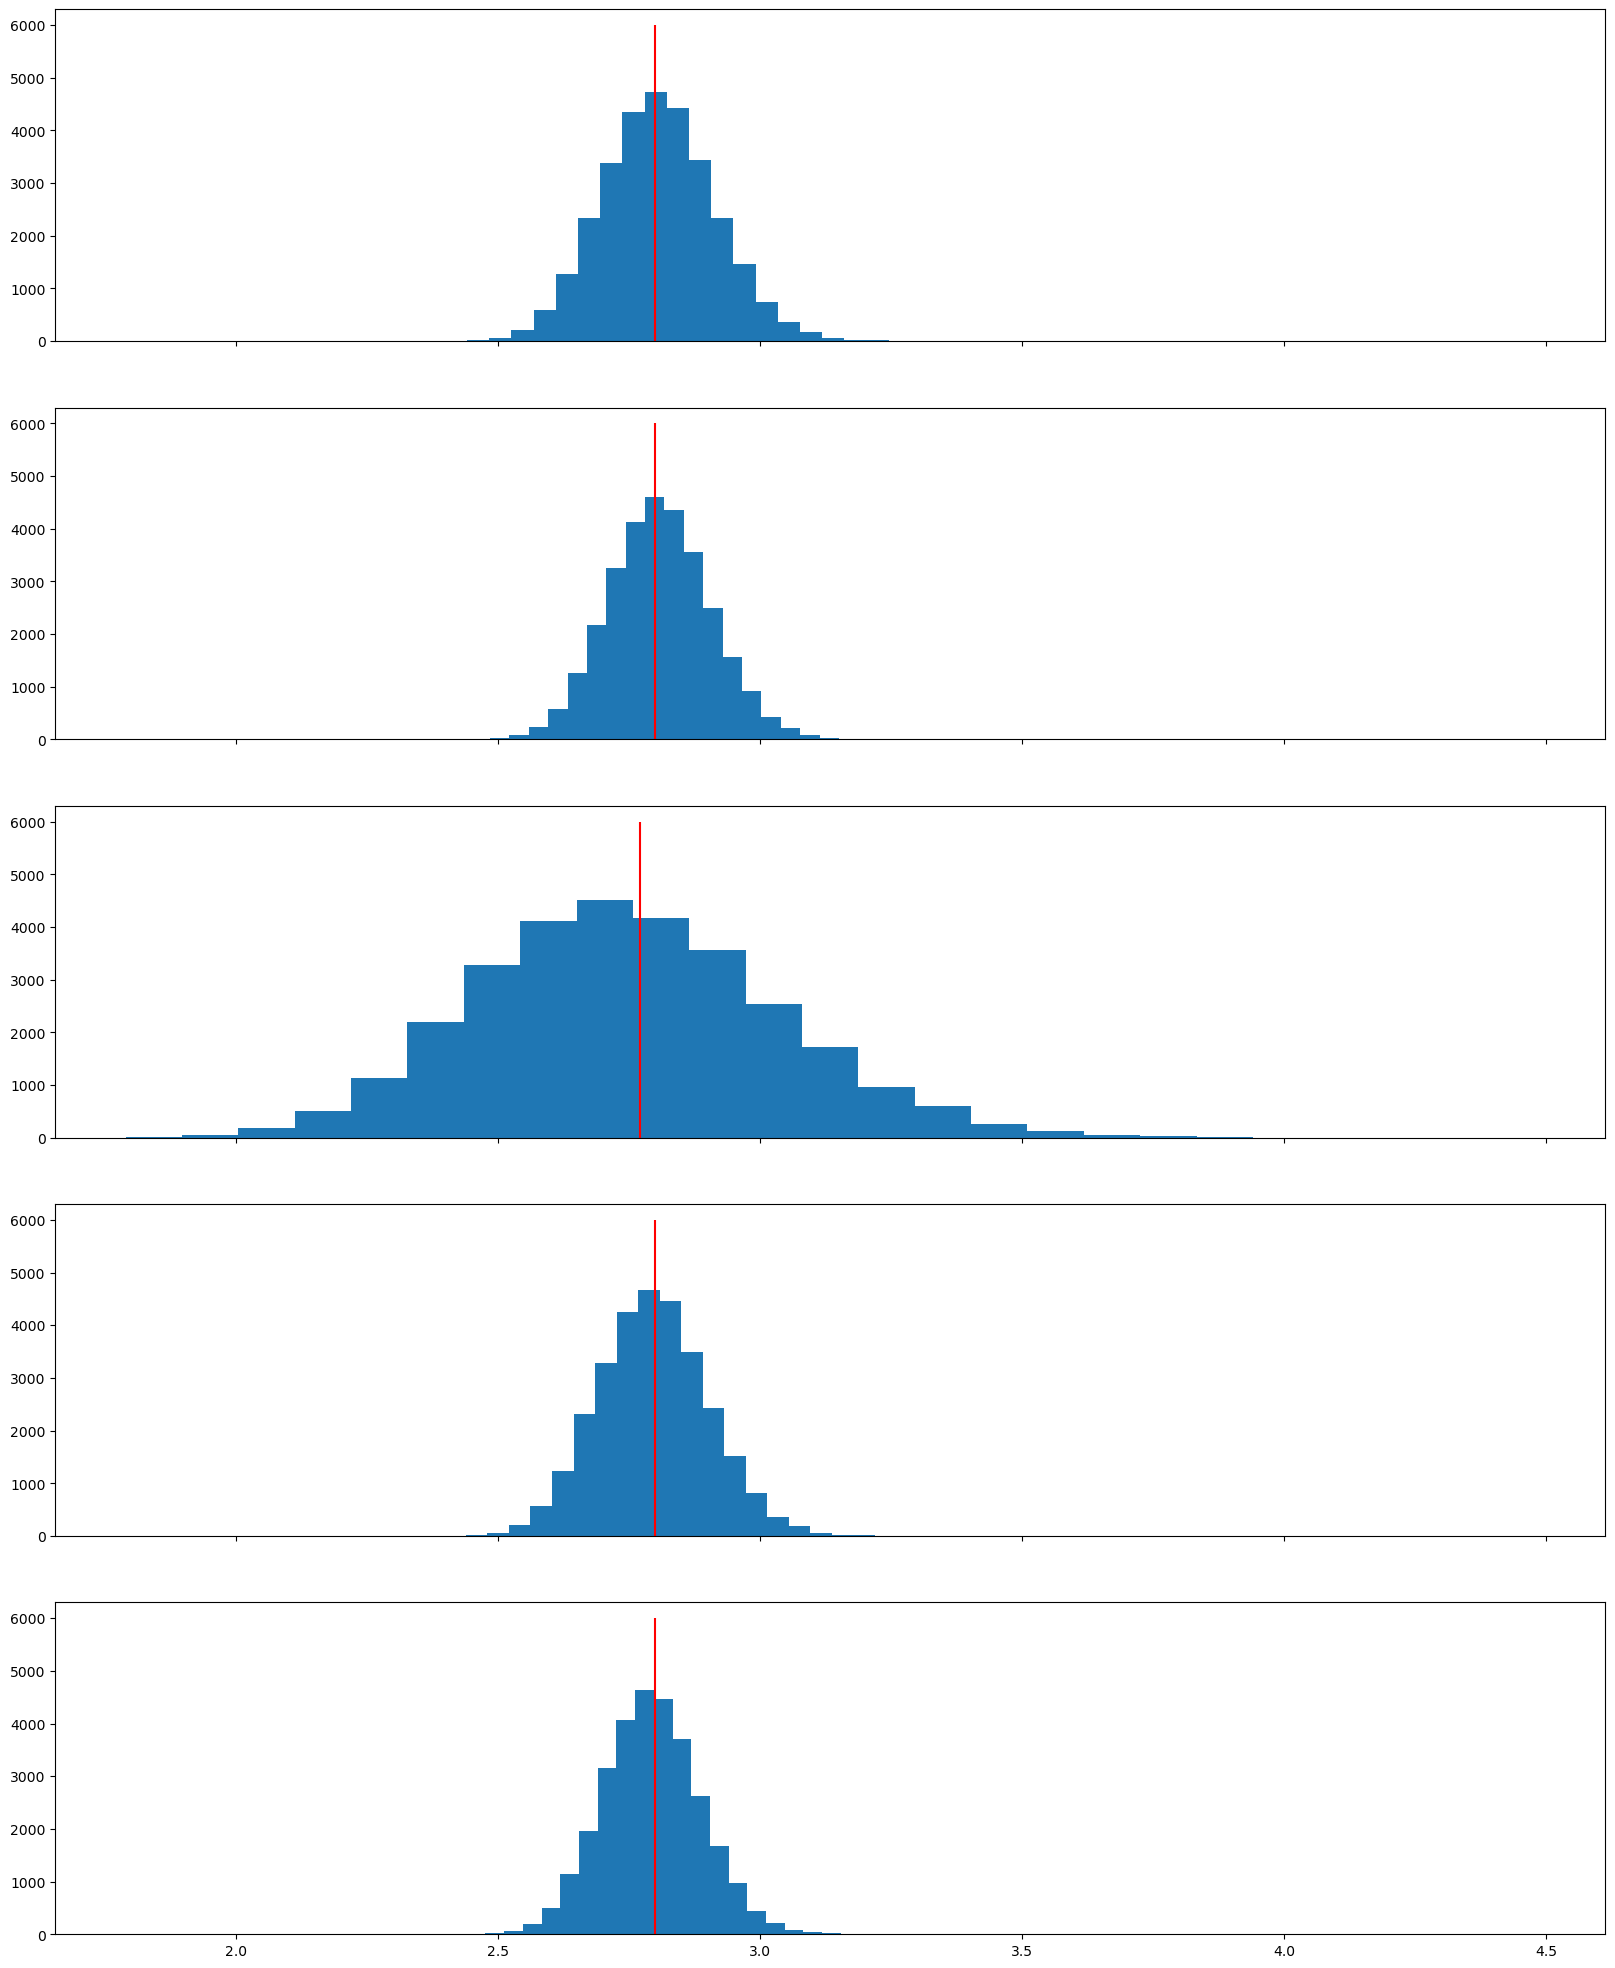

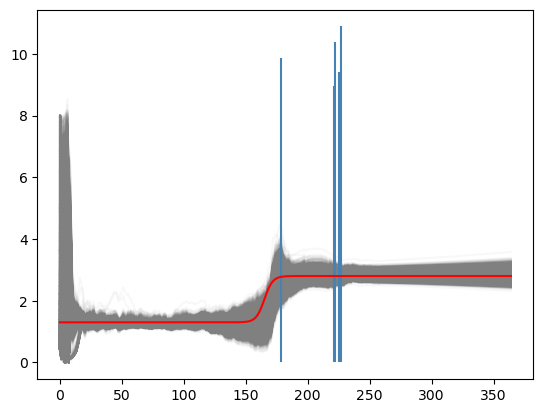

In [384]:
best_scores_after_midpoint_idx = eakf.data.midpoint + np.argsort(percentiles_mean_run[eakf.data.midpoint:])[:5]

blah_list = []

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle_rt(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    blah_list.append(post_rts[best_scores_after_midpoint_idx,:])

fig, axs = plt.subplots(5, figsize=(20,25), sharex=True)
for i, ax in enumerate(axs.flat):
    ax.hist(np.array(blah_list)[:,i,:].flatten(), bins=25)
    ax.vlines(truth[best_scores_after_midpoint_idx[i]], 0, 6000, color='red')


fig, ax = plt.subplots()

for run in range(100):
    file = run_dir + f"{pp}_adaptive_inflation_run_{run}.pkl"
    eakf = open_pickle_rt(file)
    post_rts = np.array([θ.beta * θ.t_I for θ in eakf.θ_list])
    ax.plot(post_rts, color='gray', alpha=0.05)

for day in best_scores_after_midpoint_idx:
    ax.vlines(day, 0.01, ax.get_ylim()[1], color='steelblue', label='last epi day')
ax.plot(truth, color='r')
